

# Solución Integral Segmentación. Auto3DSeg. Ejemplo simple con Autorunner

En este cuaderno, proporcionaremos una demostración simple de cómo utilizar Auto3DSeg AutoRunner para procesar un conjunto de datos simulados y generar resultados en muy pocos minutos

[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franguerrero/TFM_SegmentacionImagenesMedicas/blob/main/cuadernos_jupyter/TFM_SolucionIntegralSegmentacion_Auto3DSeg_Autorunner.ipynb)

## Setup del entorno

Verificamos si está conectado con la GPU y mostramos la información de la GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('fallo') >= 0:
  print('No conectado a GPU')
else:
  print(gpu_info)

Sun Feb  5 08:57:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
# Necesitamos estas versiones para que funcione correctamente
!pip install nibabel==4.0.2 fire==0.4.0 scikit-image==0.19.3 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 17.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=33213b87b1a2b9bc039e6adea043b3fb2c99c0088aec9aa911dedf5284db2159
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [4]:
# Instalamos las librerias de MONAI en su ultima versión estable que en el momento de la realización de este cuaderno es la 1.1.0

!pip install -q "monai[nibabel, tqdm, einops, yaml]"==1.1.0
#!python -c "import monai" || pip install -q "monai-weekly[nibabel, yaml, tqdm]"
#!python -c "import monai" || pip install -q "monai[all]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.1 MB/s eta 0:00:00


## Setup de imports

In [5]:
# Importamos aquellas librerias que nos van a hacer falta tanto de MONAI como otras como de numpy o matplotlib
# Finalizamos viendo las versiones instaladas de cada una de ellas

import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai.data import create_test_image_3d

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Conjunto de datos simulados

Para disminuir los tiempos de entrenamiento, en lugar de usar imágenes reales de CT que llevarían mucho tiempo de entrenar, se van a simular un conjunto de datos de entrenamiento con una geometría mucho más simple de la que sería un dato real y se va a entrenar al modelo usando muy pocas iteraciones (épocas) con el objetivo de demostrar todos el proceso. Los resultados que se obtendran no serán nada precisos, pero el objetivo ahora sería ver todo el proceso en un tiempo razonable independientemente de la calidad de precision del modelo resultante.

Nos creamos tambien la variable sim_datalist que proporciona la información de los conjuntos de datos simulados. En él se listan 12 imágenes de entrenamiento y 2 de pruebas. 

Los datos de entrenamiento se dividen en 3 grupos. Cada grupo utilizará 8 imágenes para entrenar y 4 para validar. El tamaño de la dimensión se define por sim_dim.Cada conjunto de validación solo tiene 4 imágenes en un grupo de entrenamiento.

sim_datalist es el equivalente a dataset_0.json que hemos usado en los otros cuadernos


In [6]:
sim_datalist = {
    "testing": [
        {"image": "test_image_001.nii.gz", "label": "test_label_001.nii.gz"},
        {"image": "test_image_002.nii.gz", "label": "test_label_002.nii.gz"},
    ],
    "training": [
        {"fold": 0, "image": "tr_image_001.nii.gz", "label": "tr_label_001.nii.gz"},
        {"fold": 0, "image": "tr_image_002.nii.gz", "label": "tr_label_002.nii.gz"},
        {"fold": 0, "image": "tr_image_003.nii.gz", "label": "tr_label_003.nii.gz"},
        {"fold": 0, "image": "tr_image_004.nii.gz", "label": "tr_label_004.nii.gz"},
        {"fold": 1, "image": "tr_image_005.nii.gz", "label": "tr_label_005.nii.gz"},
        {"fold": 1, "image": "tr_image_006.nii.gz", "label": "tr_label_006.nii.gz"},
        {"fold": 1, "image": "tr_image_007.nii.gz", "label": "tr_label_007.nii.gz"},
        {"fold": 1, "image": "tr_image_008.nii.gz", "label": "tr_label_008.nii.gz"},
        {"fold": 2, "image": "tr_image_009.nii.gz", "label": "tr_label_009.nii.gz"},
        {"fold": 2, "image": "tr_image_010.nii.gz", "label": "tr_label_010.nii.gz"},
        {"fold": 2, "image": "tr_image_011.nii.gz", "label": "tr_label_011.nii.gz"},
        {"fold": 2, "image": "tr_image_012.nii.gz", "label": "tr_label_012.nii.gz"},
    ],
}

sim_dim = (64, 64, 64)

#  debemos establecer un límite en el número total de GPUs que estamos utilizando. Al ser con Colab solo tendremos 1 GPU
if torch.cuda.device_count() > 4:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

## Generar imágenes y etiquetas simuladsa
Utilizamos las funciones 'create_test_image_3d' de MONAI y 'nib.Nifti1Image' para generar las imágenes 3D simuladas en el directorio de trabajo "./solucionintegralsegmentacion".

In [7]:
work_dir = "./solucionintegralsegmentacion"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(sim_datalist, f)

for d in sim_datalist["testing"] + sim_datalist["training"]:
    im, seg = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )
    image_fpath = os.path.join(dataroot_dir, d["image"])
    label_fpath = os.path.join(dataroot_dir, d["label"])
    nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
    nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

## Inspeccionar los datos simulados

Seleccionamos uno de los datos de prueba para tener una idea de como es la imagen simulada y la etiqueta

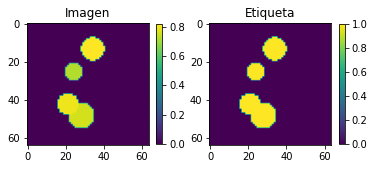

In [8]:
img_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["image"]))
lbl_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["label"]))
img = np.array(img_nib.dataobj)
lbl = np.array(lbl_nib.dataobj)
plt.subplot(1, 2, 1)
plt.imshow(img[32])
plt.title("Imagen")
cbar = plt.colorbar(shrink=0.55)
plt.subplot(1, 2, 2)
plt.imshow(lbl[32])
plt.title("Etiqueta")
cbar = plt.colorbar(shrink=0.55)

## Ejecutar el AutoRunner de la Solución Integral de Auto3DSeg

`AutoRunner`automáticamente configurará cuatro redes neuronales diferentes y realizará un entrenamiento multigrupo para lograr el mejor rendimiento. El módulo es altamente configurable y solo requiere una entrada mínima. 

Configuramos el Autorunner:

In [9]:
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    },
)

2023-02-05 08:58:02,648 - INFO - AutoRunner using work directory ./solucionintegralsegmentacion
2023-02-05 08:58:02,653 - INFO - The output_dir is not specified. /content/solucionintegralsegmentacion/ensemble_output will be used to save ensemble predictions
2023-02-05 08:58:02,654 - INFO - Directory /content/solucionintegralsegmentacion/ensemble_output is created to save ensemble predictions


## Configuracion para ejecución rápida
Sobrescribimos los parámetros de entrenamiento para que podamos completar el pipeline en pocos minutos.

In [10]:
max_epochs = 2

# safeguard to ensure max_epochs is greater or equal to 2
# aseguramos que el numero de epocas sea al menos de 2
max_epochs = max(max_epochs, 2)

train_param = {
    "CUDA_VISIBLE_DEVICES": [0],  # usamos solo una GPU puesto que es lo que tiene colab
    "num_iterations": 4 * max_epochs,
    "num_iterations_per_validation": 2 * max_epochs,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_iterations": 2 * max_epochs,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

## Ejecutamos el Autorunner
Autorruner realiza el análisis de datos, generación de algoritmos, entrenamiento y ensamblado de modelos.

In [11]:
runner.run()

2023-02-05 08:58:02,680 - INFO - Running data analysis...


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]
algo_templates.tar.gz: 64.0kB [00:00, 182kB/s]                             

2023-02-05 08:58:10,211 - INFO - Downloaded: /tmp/tmp8qt_n4eb/algo_templates.tar.gz
2023-02-05 08:58:10,213 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp8qt_n4eb/algo_templates.tar.gz.
2023-02-05 08:58:10,214 - INFO - Writing into directory: /content/solucionintegralsegmentacion.


2023-02-05 08:58:11,075 - INFO - /content/solucionintegralsegmentacion/segresnet2d_0
2023-02-05 08:58:11,572 - INFO - /content/solucionintegralsegmentacion/dints_0
2023-02-05 08:58:12,013 - INFO - /content/solucionintegralsegmentacion/swinunetr_0
Loaded self.data_list_file /content/solucionintegralsegmentacion/input.yaml
2023-02-05 08:58:12,592 - INFO - /content/solucionintegralsegmentacion/segresnet_0
2023-02-05 08:58:12,616 - INFO - Launching: python /content/solucionintegralsegmentacion/dints_0/scripts/search.py run --config_file='/content/solucionintegralsegmentacion/dints_0/configs/transforms_validate.yaml','/content/solucionintegralsegmentacion/dints_0/configs/hyper_parameters.yaml','/content/solucionintegralsegmentacion/dints_0/configs/network.yaml','/content/solucionintegralsegmentacion/dints_0/configs/transforms_train.yaml','/content/solucionintegralsegmentacion/dints_0/configs/transforms_infer.yaml','/content/solucionintegralsegmentacion/dints_0/configs/network_search.yaml','

## Inspeccionar las predicciones ensambladas del algoritmo y compararlas con el Ground Truth (GT)

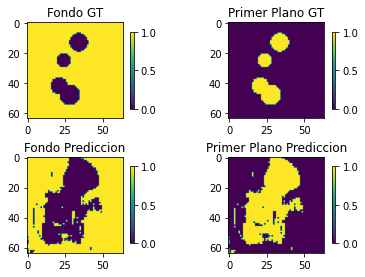

In [12]:
image_name = sim_datalist["testing"][0]["image"].split(".")[0]
prediction_nib = nib.load(os.path.join(work_dir, "ensemble_output", image_name, image_name + "_ensemble" + ".nii.gz"))
pred = np.array(prediction_nib.dataobj)

img_slice32 = lbl[32] == 0
label_slice32 = lbl[32] == 1
background_slice32 = pred[32, :, :, 0] if pred.ndim == 4 else pred[32] == 0
foreground_slice32 = pred[32, :, :, 1] if pred.ndim == 4 else pred[32] == 1

plt.subplot(2, 2, 1)
plt.imshow(img_slice32)
plt.title("Fondo GT")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 2)
plt.imshow(label_slice32)
plt.title("Primer Plano GT")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 3)
plt.imshow(background_slice32)
plt.title("Fondo Prediccion")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 4)
plt.imshow(foreground_slice32)
plt.title("Primer Plano Prediccion")
cbar = plt.colorbar(shrink=0.8)
# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## Conclusion

Podemos ver que los algoritmos comienzan a aprender los conjuntos de datos y la predicción de vóxeles de fondo y primer plano. Auto3DSeg y AutoRunner son altamente configurables. Para obtener mejores resultados, se puede aumentar el tiempo de entrenamiento, aplicar un método de ensamblado diferente o utilizar la optimización de hiperparámetros a través de las APIs de módulo AutoRunner o Auto3DSeg.